In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

In [2]:
# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
# Convert SignupDate to datetime format
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])

In [4]:
# Calculate Signup Age (days since signup)
customers["SignupAge"] = (pd.to_datetime("today") - customers["SignupDate"]).dt.days

In [5]:
# Aggregate transaction data per customer
customer_transactions = transactions.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    total_transactions=("TransactionID", "count"),
    avg_spent_per_trans=("TotalValue", "mean")
).reset_index()

In [6]:
# Extract most purchased category per customer
top_category = transactions.groupby(["CustomerID", "ProductID"]).size().reset_index(name='count')
top_category = top_category.loc[top_category.groupby("CustomerID")["count"].idxmax(), ["CustomerID", "ProductID"]]

In [7]:
# Merge customer data with transaction data
customers = customers.merge(customer_transactions, on="CustomerID", how="left")
customers = customers.merge(top_category, on="CustomerID", how="left")

In [8]:
# Encode categorical features (Region)
encoder = LabelEncoder()
customers["Region"] = encoder.fit_transform(customers["Region"])

In [9]:
# Fill missing values with 0
customers.fillna(0, inplace=True)

In [10]:
# Select features for clustering
features = ["Region", "SignupAge", "total_spent", "total_transactions", "avg_spent_per_trans"]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customers[features])

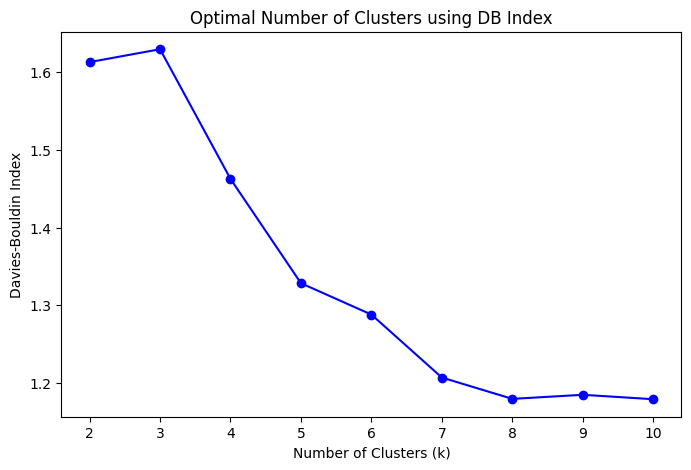

In [11]:
# Determine the best number of clusters using DB Index
db_scores = []
clusters_range = range(2, 11)

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, labels)
    db_scores.append(db_index)

# Plot DB Index scores
plt.figure(figsize=(8, 5))
plt.plot(clusters_range, db_scores, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.title("Optimal Number of Clusters using DB Index")
plt.show()

In [12]:
# Choose the best k (where DB Index is lowest)
optimal_k = clusters_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")


Optimal number of clusters: 10


In [13]:
# Train K-Means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customers["ClusterID"] = kmeans.fit_predict(scaled_data)

In [14]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

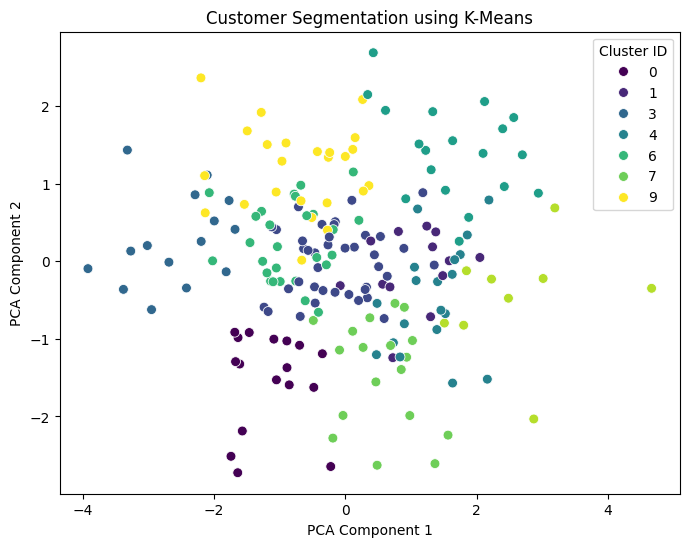

In [15]:
# Scatter plot of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=customers["ClusterID"], palette="viridis", s=50)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Segmentation using K-Means")
plt.legend(title="Cluster ID")
plt.show()

In [17]:
# Save cluster results
customers[["CustomerID", "ClusterID"]].to_csv("Vepuri_Richitha_Clustering.csv", index=False)
print("Vepuri_Richitha_Clustering.csv created successfully!")

Vepuri_Richitha_Clustering.csv created successfully!
